In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from collections import Counter

In [2]:
def data_load(PATH):
    visit_occurrence = pd.read_csv(PATH+'/visit_occurrence.csv')
    person = pd.read_csv(PATH+'/person.csv')
    condition_occurrence = pd.read_csv(PATH+'/condition_occurrence.csv')
    drug_exposure = pd.read_csv(PATH+'/drug_exposure.csv')
    concept = pd.read_csv(PATH+'/concept.csv')
    death = pd.read_csv(PATH+'/death.csv')
    
    person = person[['person_id','gender_concept_id','birth_datetime','race_concept_id','ethnicity_concept_id']]
    visit_occurrence = visit_occurrence[['visit_occurrence_id','person_id','visit_concept_id','visit_start_datetime',
                                         'visit_end_datetime']]
    condition_occurrence = condition_occurrence[['person_id','condition_concept_id','condition_start_datetime',
                                                 'condition_end_datetime','visit_occurrence_id']]
    drug_exposure = drug_exposure[['person_id','drug_concept_id','drug_exposure_start_datetime',
                                   'drug_exposure_end_datetime','visit_occurrence_id']]
    concept = concept[['concept_id','concept_name','domain_id']]
    death = death[['person_id','death_date']]
    
    return visit_occurrence,person,condition_occurrence,drug_exposure,concept,death

In [3]:
visit_occurrence,person,condition_occurrence,drug_exposure,concept,death = data_load("/content/drive/MyDrive/Colab Notebooks/linewalks")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
VER1 = pd.merge(person, visit_occurrence, on ='person_id', how = 'right')
# merge의 결과로 하나의 방문에 (visit_start_datetime이 같음) 여러 visit_occurrence_id가 삽입되는 경우가 존재함
# 그러나 person_id와 visit_start_datetime을 기준으로 중복되는 데이터를 삭제하지 않음 ==> 진단명에 따라 달라지는 경우가 존재하기에 삭제x

VER1_test = VER1.copy()
# 입원비율

# 애초에 입원 비율이 낮음. 그렇다면 전체 환자 중 재입원 비율은 3%, 
len(VER1_test[VER1_test['visit_concept_id']==9201])/len(VER1_test)

0.03130829944989237

In [5]:
def make_datetime(VER1):
    VER1_test = VER1.copy()
    VER1_test['birth_datetime']       = pd.to_datetime(VER1_test['birth_datetime'])
    VER1_test['visit_start_datetime'] = pd.to_datetime(VER1_test['visit_start_datetime'])
    VER1_test['visit_end_datetime']   = pd.to_datetime(VER1_test['visit_end_datetime'])
    return VER1_test

def make_targetVariable(VER1):
    VER1_test = VER1.copy()
    VER1_test = VER1_test[VER1_test['visit_concept_id']==9201].reset_index(drop = True) # 재입원률을 계산하는 것이므로 입원 환자만
    VER1_test['target'] = 0

    for personId, target_df in VER1_test.groupby(by = ['person_id']):
        # 환자 ID를 기준으로 재입원을 계산
        target_df = target_df.sort_values(by = ['visit_start_datetime'], axis = 0)
        target_df['timedelta'] = target_df['visit_start_datetime'] - target_df['visit_end_datetime'].shift(1)
        target_df['timedelta'] = target_df['timedelta'].apply(lambda x: x.days)
        target_df = target_df[(target_df['timedelta']>0)&(target_df['timedelta']<=30)].reset_index(drop = True)

        list_Id = list(target_df['visit_end_datetime'].unique())
        # visit_end_datetime을 기준으로 조회하는 이유는 여러 visit_occurrence_id가 기록되는 경우 존재. 
        # 아마 입원 중에 연속해서 각기 다른 병 진단이 내려진 것으로 추정
        VER1_test.loc[(VER1_test['visit_end_datetime'].isin(list_Id))&(VER1_test['person_id']==personId), 'target'] =1
    return VER1_test



In [6]:
VER1_test1 = make_datetime(VER1_test).copy()
VER1_test2 = make_targetVariable(VER1_test1).copy()


In [7]:
len(VER1_test2[VER1_test2['target']==1])/len(VER1_test2)
#재입원률은 약 24.5퍼센트

0.2452253628724217

In [8]:
# 한 번 방문했을 때 진단받은 condition과 drug를 리스트로 만들어서 변수화함

def condition_conceptList(row,condition_occurrence):
    
    visit_occurrence_id = row['visit_occurrence_id']
    target_df = condition_occurrence[condition_occurrence['visit_occurrence_id']==visit_occurrence_id].copy()
    List_concept = list(target_df['condition_concept_id'].unique())
    return List_concept

def drug_conceptList(row,drug_exposure):
    
    visit_occurrence_id = row['visit_occurrence_id']
    target_df = drug_exposure[drug_exposure['visit_occurrence_id']==visit_occurrence_id].copy()
    List_concept = list(target_df['drug_concept_id'].unique())
    return List_concept

def make_ConditionDrug(VER1,condition_occurrence,drug_exposure):
    VER1_test2 = VER1.copy()
    VER1_test2['condition_conceptList'] = VER1_test2.apply(lambda x: condition_conceptList(x,condition_occurrence),axis = 1)
    VER1_test2['drug_conceptList'] = VER1_test2.apply(lambda x: drug_conceptList(x,drug_exposure),axis = 1)
    
    return VER1_test2



In [9]:
VER1_test2 = make_ConditionDrug(VER1_test2,condition_occurrence,drug_exposure).copy()

In [10]:
# gender, race를 보기 쉽게 숫자코드가 아닌 문자로 변환

def gender_concept(row, concept):
    gender_concept_id = row
    concept_name = concept[concept['concept_id']==gender_concept_id]['concept_name'].values
    return concept_name[0]

def race_concept(row, concept):
    race_concept_id = row
    concept_name = concept[concept['concept_id']==race_concept_id]['concept_name'].values
    return concept_name[0]


def make_GenderRace(VER1,concept):
    VER1_test2 = VER1.copy()
    VER1_test2['gender_concept_name']    = VER1_test2['gender_concept_id'].apply(lambda x: gender_concept(x, concept))
    VER1_test2['race_concept_name']      = VER1_test2['race_concept_id'].apply(lambda x: race_concept(x, concept))
    return VER1_test2

In [11]:
VER1_test2 = make_GenderRace(VER1_test2,concept).copy()

In [12]:
def make_patientAge(VER1):
    #환자 나이 계산 시점을 퇴원시기로 잡은 이유는 모델 가동시기가 퇴원시점이기 때문
    VER1_test2 = VER1.copy()
    VER1_test2['patientAge'] = VER1_test2['visit_end_datetime']-VER1_test2['birth_datetime']

    VER1_test2['patientAge'] = VER1_test2['patientAge'].apply(lambda x: round(x.days/365.25))
    
    return VER1_test2

In [13]:
VER1_test2 = make_patientAge(VER1_test2).copy()

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


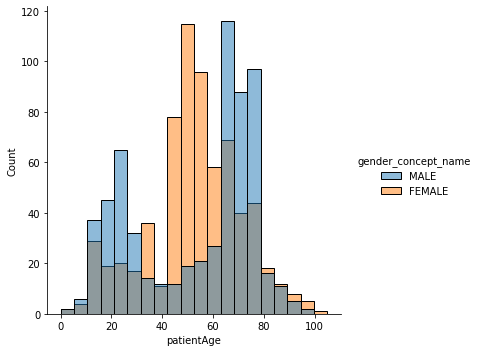

In [14]:
#입원환자 케이스의 성별간 나이 분포
sns.displot(VER1_test2, x = 'patientAge',bins = 20, hue = 'gender_concept_name' )

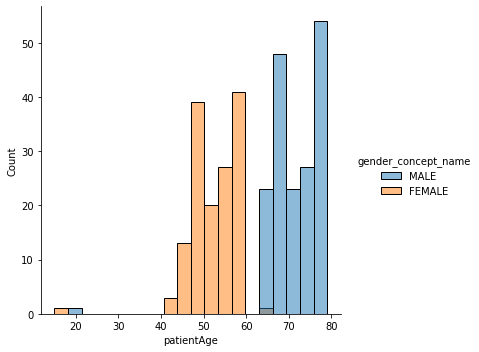

In [15]:
#재입원한 환자 케이스의 성별간 나이 분포
sns.displot(VER1_test2[VER1_test2['target']==1], x = 'patientAge',bins = 20, hue = 'gender_concept_name' )

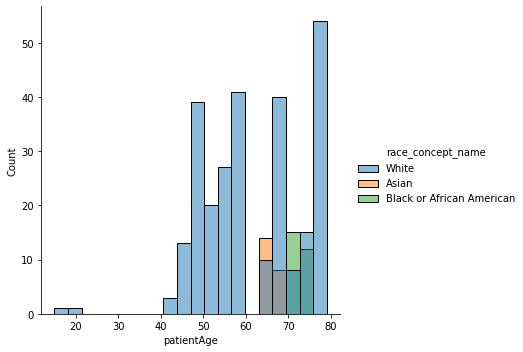

In [16]:
#입원환자 케이스 중 인종 분포
sns.displot(VER1_test2[VER1_test2['target']==1], x = 'patientAge',bins = 20, hue = 'race_concept_name' )

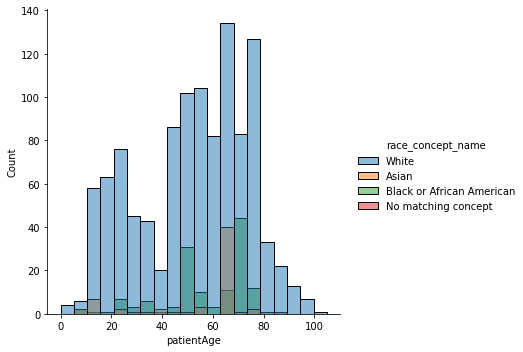

In [17]:
#재입원한 환자 케이스의 인종 분포
sns.displot(VER1_test2, x = 'patientAge',bins = 20, hue = 'race_concept_name' )

In [18]:
white = len(VER1_test2[(VER1_test2['race_concept_name']=='White')&(VER1_test2['target']==1)])/len(VER1_test2[VER1_test2['race_concept_name']=='White'])
Asian = len(VER1_test2[(VER1_test2['race_concept_name']=='Asian')&(VER1_test2['target']==1)])/len(VER1_test2[VER1_test2['race_concept_name']=='Asian'])
Black = len(VER1_test2[(VER1_test2['race_concept_name']=='Black or African American')&(VER1_test2['target']==1)])/len(VER1_test2[VER1_test2['race_concept_name']=='Black or African American'])

print("백인 재입원 비율 : {:.2F}".format(white))
print("동양인 재입원 비율 : {:.2F}".format(Asian))
print("흑인 재입원 비율 : {:.2F}".format(Black))
# 비록 백인과 동양인, 흑인의 비율이 각각 다르지만(백인이 압도적으로 많음)
# 인종별 재입원율이 최대 15%가량 차이가 나는 것으로 확인됨


백인 재입원 비율 : 0.25
동양인 재입원 비율 : 0.35
흑인 재입원 비율 : 0.20


In [19]:
def print_targetRatioConcept(VER1):
    VER1_test2  = VER1.copy()
    target_idx  = []
    target_idx2 = []
    for idx in VER1_test2.index:
        if len(VER1_test2.at[idx, 'condition_conceptList'])==0 :
            target_idx.append(idx)
            if VER1_test2.at[idx, 'target'] ==1 :
                target_idx2.append(idx)
    print("컨디션 컨셉이 0인 경우 재입원 비율 : {:.2F}".format(len(target_idx2)/len(target_idx)))

    target_idx_2  = []
    target_idx2_2 = []
    for idx in VER1_test2.index:
        if len(VER1_test2.at[idx, 'drug_conceptList'])==0 :
            target_idx_2.append(idx)
            if VER1_test2.at[idx, 'target'] ==1 :
                target_idx2_2.append(idx)

    print("약물 컨셉이 0인 경우 재입원 비율 : {:.2F}".format(len(target_idx2_2)/len(target_idx_2)))



In [20]:
print_targetRatioConcept(VER1_test2)
# 컨디션 컨셉이 0인 경우는 재입원 비율이 평균보다 높음
# 약물 컨셉이 0인 경우는 재입원 비율이 거의 없음

컨디션 컨셉이 0인 경우 재입원 비율 : 0.33
약물 컨셉이 0인 경우 재입원 비율 : 0.04


In [21]:
list_of_cast_names = list(VER1_test2[VER1_test2['target']==1]['condition_conceptList'].apply(lambda x: [i for i in x] if len(x) != 0 else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(40)
#condition_concept은 재입원의 경우를 특정하기 어려움


[(40481087, 1), (4309027, 1), (255848, 1), (437390, 1), (4158346, 1)]

In [22]:
list_of_cast_names = list(VER1_test2[VER1_test2['target']==1]['drug_conceptList'].apply(lambda x: [i for i in x] if len(x) != 0 else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(40)
#drug_concept은 재입원의 경우를 특정가능해보임. 
#1378388,35604087의 경우는 동일한 숫자를 지닌 것으로 보아 같이 처방되는 약으로 추정


[(1378388, 296),
 (35604087, 296),
 (1713671, 1),
 (40224172, 1),
 (40169281, 1),
 (19127663, 1),
 (40171902, 1),
 (19018935, 1),
 (40163554, 1),
 (40213154, 1),
 (40174880, 1),
 (40231925, 1),
 (40160973, 1),
 (19020053, 1)]

In [23]:
def make_PeriodYear(VER1):
    VER1_test3 = VER1.copy()
    VER1_test3['period'] = VER1_test3['visit_end_datetime']-VER1_test3['visit_start_datetime']
    VER1_test3['period'] = VER1_test3['period'].apply(lambda x: x.days)
    VER1_test3['visit_start_y'] = VER1_test3['visit_start_datetime'].apply(lambda x: x.year)
    
    return VER1_test3

#EDA결과물을 데이터에 반영
def make_dataProcessed(VER1):
    VER1_test3 = VER1.copy()
    VER1_test3['lenzero_condition_conceptList'] = VER1_test3['condition_conceptList'].apply(lambda x: 1 if len(x)==0 else 0)
    VER1_test3['lenzero_drug_conceptList'] = VER1_test3['drug_conceptList'].apply(lambda x: 1 if len(x)==0 else 0)
    VER1_test3['gender_concept_name'] = VER1_test3['gender_concept_name'].apply(lambda x: 1 if x =="MALE" else 0)
    VER1_test3['drug_special'] = 0

    # EDA결과로 나온 약물 처방 변수 조작
    for idx in VER1_test3.index:
        if 1378388 in VER1_test3.at[idx, 'drug_conceptList']:
            VER1_test3.at[idx, 'drug_special'] = 1
    # 인종변수 인코딩
    VER1_test3['race_concept_name'] = VER1_test3['race_concept_name'].apply(lambda x: 0 if x=="White" else (1 if x =='Asian' else -1))

    VER1_test3 = VER1_test3[['target', 'gender_concept_name',
           'race_concept_name', 'patientAge', 'period', 'visit_start_y',
           'lenzero_condition_conceptList', 'lenzero_drug_conceptList',
           'drug_special']]
    
    return VER1_test3

In [24]:
VER1_test3 = make_PeriodYear(VER1_test2).copy()
VER1_test3 = make_dataProcessed(VER1_test3).copy()
VER1_test3

,target,gender_concept_name,race_concept_name,patientAge,period,visit_start_y,lenzero_condition_conceptList,lenzero_drug_conceptList,drug_special
0,0,1,0,68,1,2017,0,1,0
1,1,1,0,68,1,2017,1,1,0
2,1,1,0,68,41,2017,1,1,0
3,1,1,0,68,40,2017,1,1,0
4,1,1,0,68,39,2017,1,1,0
...,...,...,...,...,...,...,...,...,...
1304,0,0,0,77,1,2013,1,1,0
1305,0,0,0,82,1,2018,1,1,0
1306,0,1,0,68,1,2005,1,0,0
1307,0,1,0,64,11,2020,0,0,0


In [36]:
import lightgbm as lgb
from sklearn.metrics import *
from sklearn.model_selection import KFold

params = {'bagging_fraction': 0.6,
 'learning_rate': 0.05,
 'max_depth': 20,
 'num_boost_round': 700,
 'num_leaves': 28}

train_x = VER1_test3.drop(['target'],axis = 1)
train_y = VER1_test3[['target']]

In [37]:
train_y

,target
0,0
1,1
2,1
3,1
4,1
...,...
1304,0
1305,0
1306,0
1307,0


In [41]:

# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
parameters =   {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
                'learning_rate' : params['learning_rate'],
                'max_depth': int(params['max_depth']),
                'num_leaves': int(params['num_leaves']),
                'bagging_fraction': params['bagging_fraction']
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x.loc[train_idx,:]
    y = train_y.loc[train_idx,:]
    valid_x = train_x.loc[val_idx,:]
    valid_y = train_y.loc[val_idx,:]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)

    #run traning
    model = lgb.train(
                        parameters,
                        train_set       = d_train,
                        num_boost_round = int(params['num_boost_round']),
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )

    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)

    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')


/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.915347	valid_0's pr_auc: 0.623354
[40]	valid_0's auc: 0.916172	valid_0's pr_auc: 0.643215
[60]	valid_0's auc: 0.921122	valid_0's pr_auc: 0.644277
[80]	valid_0's auc: 0.927063	valid_0's pr_auc: 0.655295
[100]	valid_0's auc: 0.927393	valid_0's pr_auc: 0.657048
[120]	valid_0's auc: 0.930693	valid_0's pr_auc: 0.669008
[140]	valid_0's auc: 0.933003	valid_0's pr_auc: 0.669758
[160]	valid_0's auc: 0.932673	valid_0's pr_auc: 0.665152
[180]	valid_0's auc: 0.934983	valid_0's pr_auc: 0.677085
[200]	valid_0's auc: 0.936634	valid_0's pr_auc: 0.683464
[220]	valid_0's auc: 0.935974	valid_0's pr_auc: 0.683341
[240]	valid_0's auc: 0.935974	valid_0's pr_auc: 0.681474
[260]	valid_0's auc: 0.935974	valid_0's pr_auc: 0.680868
[280]	valid_0's auc: 0.937624	valid_0's pr_auc: 0.684446
[300]	valid_0's auc: 0.939109	valid_0's pr_auc: 0.692554
[320]	valid_0's auc: 0.940429	valid_0's pr_auc: 0.697836
[340]	valid_0's auc: 0.940099	valid_0's pr_auc: 0.699294
[360]	valid_0's auc: 0.941419	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's auc: 0.900149	valid_0's pr_auc: 0.652339
[140]	valid_0's auc: 0.899554	valid_0's pr_auc: 0.647948
[160]	valid_0's auc: 0.899851	valid_0's pr_auc: 0.648018
[180]	valid_0's auc: 0.898661	valid_0's pr_auc: 0.646129
[200]	valid_0's auc: 0.901488	valid_0's pr_auc: 0.654504
[220]	valid_0's auc: 0.899405	valid_0's pr_auc: 0.64719
[240]	valid_0's auc: 0.906399	valid_0's pr_auc: 0.680181
[260]	valid_0's auc: 0.916518	valid_0's pr_auc: 0.715442
[280]	valid_0's auc: 0.917411	valid_0's pr_auc: 0.727899
[300]	valid_0's auc: 0.920089	valid_0's pr_auc: 0.734949
[320]	valid_0's auc: 0.92128	valid_0's pr_auc: 0.735736
[340]	valid_0's auc: 0.92247	valid_0's pr_auc: 0.73751
[360]	valid_0's auc: 0.923958	valid_0's pr_auc: 0.740285
[380]	valid_0's auc: 0.923065	valid_0's pr_auc: 0.734551
[400]	valid_0's auc: 0.923363	valid_0's pr_auc: 0.73435
[420]	valid_0's auc: 0.923661	valid_0's pr_auc: 0.736442
[440]	valid_0's auc: 0.924851	valid_0's pr_auc: 0.739517
[460]	valid_0's auc: 0.924256	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.940744	valid_0's pr_auc: 0.808054
[60]	valid_0's auc: 0.941011	valid_0's pr_auc: 0.804704
[80]	valid_0's auc: 0.942616	valid_0's pr_auc: 0.81293
[100]	valid_0's auc: 0.942081	valid_0's pr_auc: 0.80545
[120]	valid_0's auc: 0.945559	valid_0's pr_auc: 0.822044
[140]	valid_0's auc: 0.948234	valid_0's pr_auc: 0.838515
[160]	valid_0's auc: 0.946094	valid_0's pr_auc: 0.822839
[180]	valid_0's auc: 0.947164	valid_0's pr_auc: 0.833912
[200]	valid_0's auc: 0.950642	valid_0's pr_auc: 0.852167
[220]	valid_0's auc: 0.95198	valid_0's pr_auc: 0.855295
[240]	valid_0's auc: 0.954922	valid_0's pr_auc: 0.864755
[260]	valid_0's auc: 0.963216	valid_0's pr_auc: 0.891487
[280]	valid_0's auc: 0.961878	valid_0's pr_auc: 0.883488
[300]	valid_0's auc: 0.964018	valid_0's pr_auc: 0.895222
[320]	valid_0's auc: 0.964018	valid_0's pr_auc: 0.888016
[340]	valid_0's auc: 0.965891	valid_0's pr_auc: 0.902191
[360]	valid_0's auc: 0.967496	valid_0's pr_auc: 0.900878
[380]	valid_0's auc: 0.966961	valid_0

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.936062	valid_0's pr_auc: 0.760727
[40]	valid_0's auc: 0.936865	valid_0's pr_auc: 0.777739
[60]	valid_0's auc: 0.937132	valid_0's pr_auc: 0.793426
[80]	valid_0's auc: 0.937667	valid_0's pr_auc: 0.78572
[100]	valid_0's auc: 0.93954	valid_0's pr_auc: 0.796112
[120]	valid_0's auc: 0.944088	valid_0's pr_auc: 0.797488
[140]	valid_0's auc: 0.945425	valid_0's pr_auc: 0.800753
[160]	valid_0's auc: 0.945693	valid_0's pr_auc: 0.800859
[180]	valid_0's auc: 0.946763	valid_0's pr_auc: 0.805581
[200]	valid_0's auc: 0.942483	valid_0's pr_auc: 0.785059
[220]	valid_0's auc: 0.944623	valid_0's pr_auc: 0.790071
[240]	valid_0's auc: 0.947833	valid_0's pr_auc: 0.803073
[260]	valid_0's auc: 0.948368	valid_0's pr_auc: 0.843199
[280]	valid_0's auc: 0.949171	valid_0's pr_auc: 0.85389
[300]	valid_0's auc: 0.949171	valid_0's pr_auc: 0.853643
[320]	valid_0's auc: 0.948903	valid_0's pr_auc: 0.853127
[340]	valid_0's auc: 0.948903	valid_0's pr_auc: 0.853053
[360]	valid_0's auc: 0.946763	valid_0'

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's auc: 0.918864	valid_0's pr_auc: 0.549099
[140]	valid_0's auc: 0.919963	valid_0's pr_auc: 0.550378
[160]	valid_0's auc: 0.919963	valid_0's pr_auc: 0.550361
[180]	valid_0's auc: 0.919231	valid_0's pr_auc: 0.549371
[200]	valid_0's auc: 0.920696	valid_0's pr_auc: 0.556396
[220]	valid_0's auc: 0.922527	valid_0's pr_auc: 0.563238
[240]	valid_0's auc: 0.923626	valid_0's pr_auc: 0.571775
[260]	valid_0's auc: 0.922527	valid_0's pr_auc: 0.616332
[280]	valid_0's auc: 0.923626	valid_0's pr_auc: 0.620661
[300]	valid_0's auc: 0.921795	valid_0's pr_auc: 0.613398
[320]	valid_0's auc: 0.921429	valid_0's pr_auc: 0.612627
[340]	valid_0's auc: 0.921795	valid_0's pr_auc: 0.617465
[360]	valid_0's auc: 0.921795	valid_0's pr_auc: 0.617996
[380]	valid_0's auc: 0.921795	valid_0's pr_auc: 0.617477
[400]	valid_0's auc: 0.919963	valid_0's pr_auc: 0.612336
[420]	valid_0's auc: 0.919597	valid_0's pr_auc: 0.610013
[440]	valid_0's auc: 0.919597	valid_0's pr_auc: 0.610013
[460]	valid_0's auc: 0.921429	v

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.946262	valid_0's pr_auc: 0.641071
[160]	valid_0's auc: 0.94704	valid_0's pr_auc: 0.643812
[180]	valid_0's auc: 0.94743	valid_0's pr_auc: 0.645346
[200]	valid_0's auc: 0.948598	valid_0's pr_auc: 0.646498
[220]	valid_0's auc: 0.948988	valid_0's pr_auc: 0.64849
[240]	valid_0's auc: 0.950156	valid_0's pr_auc: 0.656107
[260]	valid_0's auc: 0.952882	valid_0's pr_auc: 0.669347
[280]	valid_0's auc: 0.953271	valid_0's pr_auc: 0.671682
[300]	valid_0's auc: 0.95405	valid_0's pr_auc: 0.677376
[320]	valid_0's auc: 0.954829	valid_0's pr_auc: 0.732931
[340]	valid_0's auc: 0.954829	valid_0's pr_auc: 0.690667
[360]	valid_0's auc: 0.955607	valid_0's pr_auc: 0.701029
[380]	valid_0's auc: 0.955997	valid_0's pr_auc: 0.710238
[400]	valid_0's auc: 0.957555	valid_0's pr_auc: 0.749353
[420]	valid_0's auc: 0.955997	valid_0's pr_auc: 0.741828
[440]	valid_0's auc: 0.955997	valid_0's pr_auc: 0.741828
[460]	valid_0's auc: 0.956776	valid_0's pr_auc: 0.748519
[480]	valid_0's auc: 0.957944	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	valid_0's auc: 0.926318	valid_0's pr_auc: 0.646426
[120]	valid_0's auc: 0.928051	valid_0's pr_auc: 0.653738
[140]	valid_0's auc: 0.930305	valid_0's pr_auc: 0.662053
[160]	valid_0's auc: 0.930652	valid_0's pr_auc: 0.660046
[180]	valid_0's auc: 0.930652	valid_0's pr_auc: 0.656963
[200]	valid_0's auc: 0.933079	valid_0's pr_auc: 0.665101
[220]	valid_0's auc: 0.934119	valid_0's pr_auc: 0.675935
[240]	valid_0's auc: 0.935506	valid_0's pr_auc: 0.712957
[260]	valid_0's auc: 0.936893	valid_0's pr_auc: 0.722808
[280]	valid_0's auc: 0.93828	valid_0's pr_auc: 0.738593
[300]	valid_0's auc: 0.938627	valid_0's pr_auc: 0.738965
[320]	valid_0's auc: 0.938974	valid_0's pr_auc: 0.745799
[340]	valid_0's auc: 0.940361	valid_0's pr_auc: 0.750623
[360]	valid_0's auc: 0.940014	valid_0's pr_auc: 0.742545
[380]	valid_0's auc: 0.939667	valid_0's pr_auc: 0.743449
[400]	valid_0's auc: 0.942268	valid_0's pr_auc: 0.764485
[420]	valid_0's auc: 0.939494	valid_0's pr_auc: 0.742557
[440]	valid_0's auc: 0.939147	va

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.918718	valid_0's pr_auc: 0.627806
[160]	valid_0's auc: 0.916824	valid_0's pr_auc: 0.622616
[180]	valid_0's auc: 0.91935	valid_0's pr_auc: 0.631329
[200]	valid_0's auc: 0.923453	valid_0's pr_auc: 0.645915
[220]	valid_0's auc: 0.922822	valid_0's pr_auc: 0.643129
[240]	valid_0's auc: 0.92661	valid_0's pr_auc: 0.659695
[260]	valid_0's auc: 0.925979	valid_0's pr_auc: 0.66213
[280]	valid_0's auc: 0.927872	valid_0's pr_auc: 0.707875
[300]	valid_0's auc: 0.928504	valid_0's pr_auc: 0.710246
[320]	valid_0's auc: 0.927872	valid_0's pr_auc: 0.713143
[340]	valid_0's auc: 0.928504	valid_0's pr_auc: 0.710568
[360]	valid_0's auc: 0.927241	valid_0's pr_auc: 0.7101
[380]	valid_0's auc: 0.927557	valid_0's pr_auc: 0.714684
[400]	valid_0's auc: 0.930082	valid_0's pr_auc: 0.724073
[420]	valid_0's auc: 0.930082	valid_0's pr_auc: 0.719626
[440]	valid_0's auc: 0.929766	valid_0's pr_auc: 0.717866
[460]	valid_0's auc: 0.932292	valid_0's pr_auc: 0.728982
[480]	valid_0's auc: 0.935764	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.866007	valid_0's pr_auc: 0.619442
[40]	valid_0's auc: 0.871617	valid_0's pr_auc: 0.605019
[60]	valid_0's auc: 0.876238	valid_0's pr_auc: 0.612201
[80]	valid_0's auc: 0.878548	valid_0's pr_auc: 0.616678
[100]	valid_0's auc: 0.877228	valid_0's pr_auc: 0.608716
[120]	valid_0's auc: 0.878053	valid_0's pr_auc: 0.609615
[140]	valid_0's auc: 0.888119	valid_0's pr_auc: 0.649286
[160]	valid_0's auc: 0.890099	valid_0's pr_auc: 0.648982
[180]	valid_0's auc: 0.893399	valid_0's pr_auc: 0.673028
[200]	valid_0's auc: 0.89505	valid_0's pr_auc: 0.686374
[220]	valid_0's auc: 0.89637	valid_0's pr_auc: 0.705535
[240]	valid_0's auc: 0.89835	valid_0's pr_auc: 0.711931
[260]	valid_0's auc: 0.89901	valid_0's pr_auc: 0.729601
[280]	valid_0's auc: 0.90033	valid_0's pr_auc: 0.722051
[300]	valid_0's auc: 0.89934	valid_0's pr_auc: 0.729063
[320]	valid_0's auc: 0.90099	valid_0's pr_auc: 0.732511
[340]	valid_0's auc: 0.90066	valid_0's pr_auc: 0.732437
[360]	valid_0's auc: 0.90198	valid_0's pr_a

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.905293	valid_0's pr_auc: 0.692622
[60]	valid_0's auc: 0.907207	valid_0's pr_auc: 0.691359
[80]	valid_0's auc: 0.906728	valid_0's pr_auc: 0.690246
[100]	valid_0's auc: 0.905134	valid_0's pr_auc: 0.683214
[120]	valid_0's auc: 0.917251	valid_0's pr_auc: 0.681686
[140]	valid_0's auc: 0.916932	valid_0's pr_auc: 0.6775
[160]	valid_0's auc: 0.917251	valid_0's pr_auc: 0.676804
[180]	valid_0's auc: 0.919165	valid_0's pr_auc: 0.685925
[200]	valid_0's auc: 0.919643	valid_0's pr_auc: 0.690921
[220]	valid_0's auc: 0.919643	valid_0's pr_auc: 0.694855
[240]	valid_0's auc: 0.919962	valid_0's pr_auc: 0.706183
[260]	valid_0's auc: 0.919324	valid_0's pr_auc: 0.712168
[280]	valid_0's auc: 0.916773	valid_0's pr_auc: 0.70693
[300]	valid_0's auc: 0.917411	valid_0's pr_auc: 0.710039
[320]	valid_0's auc: 0.91773	valid_0's pr_auc: 0.715166
[340]	valid_0's auc: 0.916135	valid_0's pr_auc: 0.718265
[360]	valid_0's auc: 0.915497	valid_0's pr_auc: 0.713954
[380]	valid_0's auc: 0.91486	valid_0's

In [42]:
print(np.mean(auc_scores))

0.9339505255300266


In [43]:
# 파라미터 변환 실험
# 데이터 수가 적고, auc_score가 생각보다 높으며, lightgbm을 사용했기에 오버피팅의 우려가 있어보임.
# 오버피팅에 관련한 파라미터들 추가 및 조절
params_1 = {'bagging_fraction': 0.6,
 'learning_rate': 0.05,
 'max_depth': 15, # max_depth 조절
 'num_boost_round': 700,
 'num_leaves': 25} # num_leaves 조절
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
parameters =   {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
                'learning_rate' : params_1['learning_rate'],
                'max_depth': int(params_1['max_depth']),
                'num_leaves': int(params_1['num_leaves']),
                'bagging_fraction': params_1['bagging_fraction']
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x.loc[train_idx,:]
    y = train_y.loc[train_idx,:]
    valid_x = train_x.loc[val_idx,:]
    valid_y = train_y.loc[val_idx,:]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)

    #run traning
    model = lgb.train(
                        parameters,
                        train_set       = d_train,
                        num_boost_round = int(params_1['num_boost_round']),
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )

    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)

    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')


/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.912376	valid_0's pr_auc: 0.637029
[40]	valid_0's auc: 0.914191	valid_0's pr_auc: 0.633984
[60]	valid_0's auc: 0.920792	valid_0's pr_auc: 0.653149
[80]	valid_0's auc: 0.929043	valid_0's pr_auc: 0.667432
[100]	valid_0's auc: 0.929043	valid_0's pr_auc: 0.669917
[120]	valid_0's auc: 0.930033	valid_0's pr_auc: 0.666587
[140]	valid_0's auc: 0.934323	valid_0's pr_auc: 0.670018
[160]	valid_0's auc: 0.935644	valid_0's pr_auc: 0.673421
[180]	valid_0's auc: 0.938944	valid_0's pr_auc: 0.710463
[200]	valid_0's auc: 0.937624	valid_0's pr_auc: 0.694529
[220]	valid_0's auc: 0.936304	valid_0's pr_auc: 0.686603
[240]	valid_0's auc: 0.936304	valid_0's pr_auc: 0.682829
[260]	valid_0's auc: 0.937624	valid_0's pr_auc: 0.689075
[280]	valid_0's auc: 0.937954	valid_0's pr_auc: 0.686326
[300]	valid_0's auc: 0.939439	valid_0's pr_auc: 0.69565
[320]	valid_0's auc: 0.939439	valid_0's pr_auc: 0.694571
[340]	valid_0's auc: 0.940099	valid_0's pr_auc: 0.696941
[360]	valid_0's auc: 0.940759	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.891964	valid_0's pr_auc: 0.658369
[40]	valid_0's auc: 0.891815	valid_0's pr_auc: 0.630966
[60]	valid_0's auc: 0.893452	valid_0's pr_auc: 0.632769
[80]	valid_0's auc: 0.89747	valid_0's pr_auc: 0.639853
[100]	valid_0's auc: 0.898661	valid_0's pr_auc: 0.644326
[120]	valid_0's auc: 0.898065	valid_0's pr_auc: 0.649512
[140]	valid_0's auc: 0.900149	valid_0's pr_auc: 0.652954
[160]	valid_0's auc: 0.902232	valid_0's pr_auc: 0.653908
[180]	valid_0's auc: 0.900595	valid_0's pr_auc: 0.648364
[200]	valid_0's auc: 0.9	valid_0's pr_auc: 0.654299
[220]	valid_0's auc: 0.902679	valid_0's pr_auc: 0.657904
[240]	valid_0's auc: 0.908482	valid_0's pr_auc: 0.703203
[260]	valid_0's auc: 0.917113	valid_0's pr_auc: 0.72684
[280]	valid_0's auc: 0.918601	valid_0's pr_auc: 0.734867
[300]	valid_0's auc: 0.919792	valid_0's pr_auc: 0.732817
[320]	valid_0's auc: 0.920982	valid_0's pr_auc: 0.734239
[340]	valid_0's auc: 0.923363	valid_0's pr_auc: 0.738112
[360]	valid_0's auc: 0.924256	valid_0's pr

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.943018	valid_0's pr_auc: 0.813737
[40]	valid_0's auc: 0.939139	valid_0's pr_auc: 0.791987
[60]	valid_0's auc: 0.941279	valid_0's pr_auc: 0.815436
[80]	valid_0's auc: 0.941814	valid_0's pr_auc: 0.808272
[100]	valid_0's auc: 0.943419	valid_0's pr_auc: 0.816697
[120]	valid_0's auc: 0.946094	valid_0's pr_auc: 0.824316
[140]	valid_0's auc: 0.947432	valid_0's pr_auc: 0.834298
[160]	valid_0's auc: 0.947699	valid_0's pr_auc: 0.835117
[180]	valid_0's auc: 0.947967	valid_0's pr_auc: 0.836329
[200]	valid_0's auc: 0.95091	valid_0's pr_auc: 0.852559
[220]	valid_0's auc: 0.95091	valid_0's pr_auc: 0.852559
[240]	valid_0's auc: 0.955324	valid_0's pr_auc: 0.863105
[260]	valid_0's auc: 0.964018	valid_0's pr_auc: 0.895205
[280]	valid_0's auc: 0.963216	valid_0's pr_auc: 0.891482
[300]	valid_0's auc: 0.964553	valid_0's pr_auc: 0.897394
[320]	valid_0's auc: 0.965088	valid_0's pr_auc: 0.899415
[340]	valid_0's auc: 0.968834	valid_0's pr_auc: 0.90791
[360]	valid_0's auc: 0.968566	valid_0'

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's auc: 0.943018	valid_0's pr_auc: 0.7968
[140]	valid_0's auc: 0.945693	valid_0's pr_auc: 0.805521
[160]	valid_0's auc: 0.94596	valid_0's pr_auc: 0.803972
[180]	valid_0's auc: 0.943553	valid_0's pr_auc: 0.79448
[200]	valid_0's auc: 0.943285	valid_0's pr_auc: 0.789103
[220]	valid_0's auc: 0.944623	valid_0's pr_auc: 0.793824
[240]	valid_0's auc: 0.94703	valid_0's pr_auc: 0.807521
[260]	valid_0's auc: 0.948101	valid_0's pr_auc: 0.844621
[280]	valid_0's auc: 0.948636	valid_0's pr_auc: 0.853945
[300]	valid_0's auc: 0.948636	valid_0's pr_auc: 0.853571
[320]	valid_0's auc: 0.948903	valid_0's pr_auc: 0.85302
[340]	valid_0's auc: 0.94703	valid_0's pr_auc: 0.847478
[360]	valid_0's auc: 0.946495	valid_0's pr_auc: 0.845469
[380]	valid_0's auc: 0.946495	valid_0's pr_auc: 0.845469
[400]	valid_0's auc: 0.944088	valid_0's pr_auc: 0.837185
[420]	valid_0's auc: 0.94489	valid_0's pr_auc: 0.841785
[440]	valid_0's auc: 0.94489	valid_0's pr_auc: 0.841733
[460]	valid_0's auc: 0.945158	valid_0's 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's auc: 0.920696	valid_0's pr_auc: 0.554014
[140]	valid_0's auc: 0.921062	valid_0's pr_auc: 0.554776
[160]	valid_0's auc: 0.921429	valid_0's pr_auc: 0.55576
[180]	valid_0's auc: 0.921429	valid_0's pr_auc: 0.556015
[200]	valid_0's auc: 0.923626	valid_0's pr_auc: 0.567924
[220]	valid_0's auc: 0.923993	valid_0's pr_auc: 0.569226
[240]	valid_0's auc: 0.92326	valid_0's pr_auc: 0.569611
[260]	valid_0's auc: 0.922161	valid_0's pr_auc: 0.618672
[280]	valid_0's auc: 0.925458	valid_0's pr_auc: 0.625843
[300]	valid_0's auc: 0.924359	valid_0's pr_auc: 0.624407
[320]	valid_0's auc: 0.923993	valid_0's pr_auc: 0.620666
[340]	valid_0's auc: 0.921795	valid_0's pr_auc: 0.615407
[360]	valid_0's auc: 0.923626	valid_0's pr_auc: 0.622777
[380]	valid_0's auc: 0.923993	valid_0's pr_auc: 0.625344
[400]	valid_0's auc: 0.923626	valid_0's pr_auc: 0.623639
[420]	valid_0's auc: 0.92326	valid_0's pr_auc: 0.621956
[440]	valid_0's auc: 0.922527	valid_0's pr_auc: 0.620311
[460]	valid_0's auc: 0.922527	vali

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.945678	valid_0's pr_auc: 0.639357
[160]	valid_0's auc: 0.946846	valid_0's pr_auc: 0.643135
[180]	valid_0's auc: 0.948598	valid_0's pr_auc: 0.648437
[200]	valid_0's auc: 0.947819	valid_0's pr_auc: 0.649038
[220]	valid_0's auc: 0.948209	valid_0's pr_auc: 0.648921
[240]	valid_0's auc: 0.948988	valid_0's pr_auc: 0.650708
[260]	valid_0's auc: 0.951713	valid_0's pr_auc: 0.664872
[280]	valid_0's auc: 0.950935	valid_0's pr_auc: 0.662513
[300]	valid_0's auc: 0.951713	valid_0's pr_auc: 0.672052
[320]	valid_0's auc: 0.952492	valid_0's pr_auc: 0.677806
[340]	valid_0's auc: 0.95405	valid_0's pr_auc: 0.693797
[360]	valid_0's auc: 0.955607	valid_0's pr_auc: 0.7059
[380]	valid_0's auc: 0.955218	valid_0's pr_auc: 0.705788
[400]	valid_0's auc: 0.956776	valid_0's pr_auc: 0.714954
[420]	valid_0's auc: 0.955997	valid_0's pr_auc: 0.741517
[440]	valid_0's auc: 0.955997	valid_0's pr_auc: 0.741517
[460]	valid_0's auc: 0.957165	valid_0's pr_auc: 0.7465
[480]	valid_0's auc: 0.958333	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[60]	valid_0's auc: 0.924931	valid_0's pr_auc: 0.64648
[80]	valid_0's auc: 0.926664	valid_0's pr_auc: 0.648713
[100]	valid_0's auc: 0.927011	valid_0's pr_auc: 0.651794
[120]	valid_0's auc: 0.925971	valid_0's pr_auc: 0.647504
[140]	valid_0's auc: 0.929265	valid_0's pr_auc: 0.657125
[160]	valid_0's auc: 0.930305	valid_0's pr_auc: 0.659359
[180]	valid_0's auc: 0.930652	valid_0's pr_auc: 0.656622
[200]	valid_0's auc: 0.932386	valid_0's pr_auc: 0.663651
[220]	valid_0's auc: 0.933773	valid_0's pr_auc: 0.66985
[240]	valid_0's auc: 0.9362	valid_0's pr_auc: 0.720453
[260]	valid_0's auc: 0.93828	valid_0's pr_auc: 0.731334
[280]	valid_0's auc: 0.937587	valid_0's pr_auc: 0.73424
[300]	valid_0's auc: 0.939494	valid_0's pr_auc: 0.744768
[320]	valid_0's auc: 0.939494	valid_0's pr_auc: 0.744395
[340]	valid_0's auc: 0.940534	valid_0's pr_auc: 0.749099
[360]	valid_0's auc: 0.940187	valid_0's pr_auc: 0.741897
[380]	valid_0's auc: 0.93984	valid_0's pr_auc: 0.738677
[400]	valid_0's auc: 0.941227	valid_0's

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.921244	valid_0's pr_auc: 0.639068
[160]	valid_0's auc: 0.924085	valid_0's pr_auc: 0.646247
[180]	valid_0's auc: 0.920928	valid_0's pr_auc: 0.639074
[200]	valid_0's auc: 0.922506	valid_0's pr_auc: 0.640524
[220]	valid_0's auc: 0.923769	valid_0's pr_auc: 0.645334
[240]	valid_0's auc: 0.926294	valid_0's pr_auc: 0.656375
[260]	valid_0's auc: 0.926926	valid_0's pr_auc: 0.704381
[280]	valid_0's auc: 0.928188	valid_0's pr_auc: 0.709709
[300]	valid_0's auc: 0.927872	valid_0's pr_auc: 0.709066
[320]	valid_0's auc: 0.92661	valid_0's pr_auc: 0.70569
[340]	valid_0's auc: 0.927872	valid_0's pr_auc: 0.715281
[360]	valid_0's auc: 0.930082	valid_0's pr_auc: 0.723748
[380]	valid_0's auc: 0.928819	valid_0's pr_auc: 0.714185
[400]	valid_0's auc: 0.932607	valid_0's pr_auc: 0.737666
[420]	valid_0's auc: 0.930082	valid_0's pr_auc: 0.725444
[440]	valid_0's auc: 0.929451	valid_0's pr_auc: 0.717073
[460]	valid_0's auc: 0.933239	valid_0's pr_auc: 0.731689
[480]	valid_0's auc: 0.935448	val

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.891089	valid_0's pr_auc: 0.6499
[160]	valid_0's auc: 0.894059	valid_0's pr_auc: 0.650159
[180]	valid_0's auc: 0.894224	valid_0's pr_auc: 0.671517
[200]	valid_0's auc: 0.897195	valid_0's pr_auc: 0.690133
[220]	valid_0's auc: 0.898515	valid_0's pr_auc: 0.70471
[240]	valid_0's auc: 0.899835	valid_0's pr_auc: 0.719463
[260]	valid_0's auc: 0.900165	valid_0's pr_auc: 0.72584
[280]	valid_0's auc: 0.901485	valid_0's pr_auc: 0.742946
[300]	valid_0's auc: 0.902145	valid_0's pr_auc: 0.739749
[320]	valid_0's auc: 0.901155	valid_0's pr_auc: 0.735286
[340]	valid_0's auc: 0.900825	valid_0's pr_auc: 0.730922
[360]	valid_0's auc: 0.90264	valid_0's pr_auc: 0.736938
[380]	valid_0's auc: 0.90231	valid_0's pr_auc: 0.73792
[400]	valid_0's auc: 0.89802	valid_0's pr_auc: 0.734257
[420]	valid_0's auc: 0.90066	valid_0's pr_auc: 0.73651
[440]	valid_0's auc: 0.89967	valid_0's pr_auc: 0.736297
[460]	valid_0's auc: 0.89703	valid_0's pr_auc: 0.730792
[480]	valid_0's auc: 0.89538	valid_0's pr_a

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's auc: 0.91757	valid_0's pr_auc: 0.681871
[140]	valid_0's auc: 0.91773	valid_0's pr_auc: 0.679068
[160]	valid_0's auc: 0.916614	valid_0's pr_auc: 0.672802
[180]	valid_0's auc: 0.91757	valid_0's pr_auc: 0.681371
[200]	valid_0's auc: 0.919165	valid_0's pr_auc: 0.686587
[220]	valid_0's auc: 0.920281	valid_0's pr_auc: 0.695506
[240]	valid_0's auc: 0.918048	valid_0's pr_auc: 0.696648
[260]	valid_0's auc: 0.917411	valid_0's pr_auc: 0.706528
[280]	valid_0's auc: 0.919005	valid_0's pr_auc: 0.713458
[300]	valid_0's auc: 0.916454	valid_0's pr_auc: 0.710508
[320]	valid_0's auc: 0.917092	valid_0's pr_auc: 0.713338
[340]	valid_0's auc: 0.917092	valid_0's pr_auc: 0.711817
[360]	valid_0's auc: 0.916454	valid_0's pr_auc: 0.719239
[380]	valid_0's auc: 0.91486	valid_0's pr_auc: 0.714526
[400]	valid_0's auc: 0.915497	valid_0's pr_auc: 0.718985
[420]	valid_0's auc: 0.913265	valid_0's pr_auc: 0.715088
[440]	valid_0's auc: 0.913584	valid_0's pr_auc: 0.714556
[460]	valid_0's auc: 0.916135	valid

In [44]:
print(np.mean(auc_scores))

0.9346899246452635


In [45]:
auc_scores

[0.9442244224422442,
 0.9203869047619048,
 0.970171214553237,
 0.9427501337613697,
 0.9247252747252747,
 0.9614485981308412,
 0.9394937586685159,
 0.9313446969696969,
 0.8919141914191419,
 0.920440051020408]

In [46]:
from sklearn.model_selection import StratifiedKFold
SKF = StratifiedKFold(n_splits = 10)
params_1 = {'bagging_fraction': 0.6,
 'learning_rate': 0.05,
 'max_depth': 15, # max_depth 조절
 'num_boost_round': 700,
 'num_leaves': 25} # num_leaves 조절
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
parameters =   {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
                'learning_rate' : params_1['learning_rate'],
                'max_depth': int(params_1['max_depth']),
                'num_leaves': int(params_1['num_leaves']),
                'bagging_fraction': params_1['bagging_fraction']
                }
#-------------------------------------------------------------------------------------
# 

for train_idx, val_idx in SKF.split(train_x, train_y):

    # split train, validation set
    X = train_x.loc[train_idx,:]
    y = train_y.loc[train_idx,:]
    valid_x = train_x.loc[val_idx,:]
    valid_y = train_y.loc[val_idx,:]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)

    #run traning
    model = lgb.train(
                        parameters,
                        train_set       = d_train,
                        num_boost_round = int(params_1['num_boost_round']),
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )

    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)

    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')


/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.494792	valid_0's pr_auc: 0.21771
[40]	valid_0's auc: 0.506787	valid_0's pr_auc: 0.220459
[60]	valid_0's auc: 0.512784	valid_0's pr_auc: 0.221878
[80]	valid_0's auc: 0.50363	valid_0's pr_auc: 0.222687
[100]	valid_0's auc: 0.562658	valid_0's pr_auc: 0.237929
[120]	valid_0's auc: 0.573706	valid_0's pr_auc: 0.241271
[140]	valid_0's auc: 0.573706	valid_0's pr_auc: 0.241271
[160]	valid_0's auc: 0.556345	valid_0's pr_auc: 0.236115
[180]	valid_0's auc: 0.556345	valid_0's pr_auc: 0.236115
[200]	valid_0's auc: 0.560448	valid_0's pr_auc: 0.237254
[220]	valid_0's auc: 0.561395	valid_0's pr_auc: 0.254398
[240]	valid_0's auc: 0.456439	valid_0's pr_auc: 0.23067
[260]	valid_0's auc: 0.420455	valid_0's pr_auc: 0.224
[280]	valid_0's auc: 0.415088	valid_0's pr_auc: 0.223011
[300]	valid_0's auc: 0.434186	valid_0's pr_auc: 0.226578
[320]	valid_0's auc: 0.466698	valid_0's pr_auc: 0.233272
[340]	valid_0's auc: 0.461016	valid_0's pr_auc: 0.23208
[360]	valid_0's auc: 0.521938	valid_0's pr

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 1	valid_0's pr_auc: 1
[40]	valid_0's auc: 1	valid_0's pr_auc: 1
[60]	valid_0's auc: 1	valid_0's pr_auc: 1
[80]	valid_0's auc: 1	valid_0's pr_auc: 1
[100]	valid_0's auc: 1	valid_0's pr_auc: 1
[120]	valid_0's auc: 1	valid_0's pr_auc: 1
[140]	valid_0's auc: 1	valid_0's pr_auc: 1
[160]	valid_0's auc: 1	valid_0's pr_auc: 1
[180]	valid_0's auc: 1	valid_0's pr_auc: 1
[200]	valid_0's auc: 1	valid_0's pr_auc: 1
[220]	valid_0's auc: 1	valid_0's pr_auc: 1
[240]	valid_0's auc: 1	valid_0's pr_auc: 1
[260]	valid_0's auc: 1	valid_0's pr_auc: 1
[280]	valid_0's auc: 1	valid_0's pr_auc: 1
[300]	valid_0's auc: 1	valid_0's pr_auc: 1
[320]	valid_0's auc: 1	valid_0's pr_auc: 1
[340]	valid_0's auc: 1	valid_0's pr_auc: 1
[360]	valid_0's auc: 1	valid_0's pr_auc: 1
[380]	valid_0's auc: 1	valid_0's pr_auc: 1
[400]	valid_0's auc: 1	valid_0's pr_auc: 1
[420]	valid_0's auc: 1	valid_0's pr_auc: 1
[440]	valid_0's auc: 1	valid_0's pr_auc: 1
[460]	valid_0's auc: 1	valid_0's pr_auc: 1
[480]	valid_0's

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[60]	valid_0's auc: 0.929293	valid_0's pr_auc: 0.660342
[80]	valid_0's auc: 0.929293	valid_0's pr_auc: 0.660342
[100]	valid_0's auc: 0.929293	valid_0's pr_auc: 0.660342
[120]	valid_0's auc: 0.929293	valid_0's pr_auc: 0.660342
[140]	valid_0's auc: 0.931187	valid_0's pr_auc: 0.6734
[160]	valid_0's auc: 0.931187	valid_0's pr_auc: 0.6734
[180]	valid_0's auc: 0.934659	valid_0's pr_auc: 0.679788
[200]	valid_0's auc: 0.934659	valid_0's pr_auc: 0.679788
[220]	valid_0's auc: 0.934659	valid_0's pr_auc: 0.679788
[240]	valid_0's auc: 0.928662	valid_0's pr_auc: 0.666335
[260]	valid_0's auc: 0.928662	valid_0's pr_auc: 0.666335
[280]	valid_0's auc: 0.928662	valid_0's pr_auc: 0.666335
[300]	valid_0's auc: 0.928662	valid_0's pr_auc: 0.666335
[320]	valid_0's auc: 0.928662	valid_0's pr_auc: 0.666335
[340]	valid_0's auc: 0.921717	valid_0's pr_auc: 0.649558
[360]	valid_0's auc: 0.921717	valid_0's pr_auc: 0.649558
[380]	valid_0's auc: 0.921717	valid_0's pr_auc: 0.649558
[400]	valid_0's auc: 0.922191	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[40]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[60]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[80]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[100]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[120]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[140]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[160]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[180]	valid_0's auc: 0.82197	valid_0's pr_auc: 0.362464
[200]	valid_0's auc: 0.832702	valid_0's pr_auc: 0.376177
[220]	valid_0's auc: 0.832702	valid_0's pr_auc: 0.376177
[240]	valid_0's auc: 0.832702	valid_0's pr_auc: 0.376177
[260]	valid_0's auc: 0.832702	valid_0's pr_auc: 0.376177
[280]	valid_0's auc: 0.832702	valid_0's pr_auc: 0.376177
[300]	valid_0's auc: 0.832702	valid_0's pr_auc: 0.376177
[320]	valid_0's auc: 0.833333	valid_0's pr_auc: 0.376854
[340]	valid_0's auc: 0.83649	valid_0's pr_auc: 0.380195
[360]	valid_0's auc: 0.83649	valid_0's pr_auc

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[40]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[60]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[80]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[100]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[120]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[140]	valid_0's auc: 0.699337	valid_0's pr_auc: 0.300586
[160]	valid_0's auc: 0.697443	valid_0's pr_auc: 0.302682
[180]	valid_0's auc: 0.701231	valid_0's pr_auc: 0.303599
[200]	valid_0's auc: 0.708491	valid_0's pr_auc: 0.308835
[220]	valid_0's auc: 0.708491	valid_0's pr_auc: 0.308835
[240]	valid_0's auc: 0.711016	valid_0's pr_auc: 0.310565
[260]	valid_0's auc: 0.721117	valid_0's pr_auc: 0.317252
[280]	valid_0's auc: 0.723327	valid_0's pr_auc: 0.318253
[300]	valid_0's auc: 0.723327	valid_0's pr_auc: 0.318253
[320]	valid_0's auc: 0.72459	valid_0's pr_auc: 0.309118
[340]	valid_0's auc: 0.725852	valid_0's pr_auc: 0.320097
[360]	valid_0's auc: 0.716698	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[60]	valid_0's auc: 1	valid_0's pr_auc: 1
[80]	valid_0's auc: 1	valid_0's pr_auc: 1
[100]	valid_0's auc: 1	valid_0's pr_auc: 1
[120]	valid_0's auc: 1	valid_0's pr_auc: 1
[140]	valid_0's auc: 1	valid_0's pr_auc: 1
[160]	valid_0's auc: 1	valid_0's pr_auc: 1
[180]	valid_0's auc: 1	valid_0's pr_auc: 1
[200]	valid_0's auc: 1	valid_0's pr_auc: 1
[220]	valid_0's auc: 1	valid_0's pr_auc: 1
[240]	valid_0's auc: 1	valid_0's pr_auc: 1
[260]	valid_0's auc: 0.99779	valid_0's pr_auc: 0.992479
[280]	valid_0's auc: 0.995265	valid_0's pr_auc: 0.98086
[300]	valid_0's auc: 0.99779	valid_0's pr_auc: 0.992479
[320]	valid_0's auc: 1	valid_0's pr_auc: 1
[340]	valid_0's auc: 1	valid_0's pr_auc: 1
[360]	valid_0's auc: 1	valid_0's pr_auc: 1
[380]	valid_0's auc: 1	valid_0's pr_auc: 1
[400]	valid_0's auc: 0.997159	valid_0's pr_auc: 0.989975
[420]	valid_0's auc: 0.99779	valid_0's pr_auc: 0.992479
[440]	valid_0's auc: 0.997159	valid_0's pr_auc: 0.989975
[460]	valid_0's auc: 0.990846	valid_0's pr_auc: 0.967288
[480

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.948232	valid_0's pr_auc: 0.762705
[160]	valid_0's auc: 0.948232	valid_0's pr_auc: 0.762705
[180]	valid_0's auc: 0.951231	valid_0's pr_auc: 0.769888
[200]	valid_0's auc: 0.951231	valid_0's pr_auc: 0.769888
[220]	valid_0's auc: 0.951231	valid_0's pr_auc: 0.769888
[240]	valid_0's auc: 0.951231	valid_0's pr_auc: 0.769946
[260]	valid_0's auc: 0.951231	valid_0's pr_auc: 0.769946
[280]	valid_0's auc: 0.955335	valid_0's pr_auc: 0.848359
[300]	valid_0's auc: 0.955335	valid_0's pr_auc: 0.848359
[320]	valid_0's auc: 0.955335	valid_0's pr_auc: 0.848359
[340]	valid_0's auc: 0.955335	valid_0's pr_auc: 0.848359
[360]	valid_0's auc: 0.955335	valid_0's pr_auc: 0.848359
[380]	valid_0's auc: 0.957229	valid_0's pr_auc: 0.831432
[400]	valid_0's auc: 0.957229	valid_0's pr_auc: 0.831432
[420]	valid_0's auc: 0.957229	valid_0's pr_auc: 0.831432
[440]	valid_0's auc: 0.957386	valid_0's pr_auc: 0.832206
[460]	valid_0's auc: 0.954861	valid_0's pr_auc: 0.801056
[480]	valid_0's auc: 0.954861	v

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.909091	valid_0's pr_auc: 0.797348
[40]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[60]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[80]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[100]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[120]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[140]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[160]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[180]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[200]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[220]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[240]	valid_0's auc: 0.917929	valid_0's pr_auc: 0.810606
[260]	valid_0's auc: 0.919192	valid_0's pr_auc: 0.812418
[280]	valid_0's auc: 0.919192	valid_0's pr_auc: 0.812418
[300]	valid_0's auc: 0.919192	valid_0's pr_auc: 0.812418
[320]	valid_0's auc: 0.919192	valid_0's pr_auc: 0.812418
[340]	valid_0's auc: 0.919192	valid_0's pr_auc: 0.812418
[360]	valid_0's auc: 0.919192	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.949598	valid_0's pr_auc: 0.819675
[40]	valid_0's auc: 0.956401	valid_0's pr_auc: 0.843823
[60]	valid_0's auc: 0.956401	valid_0's pr_auc: 0.843823
[80]	valid_0's auc: 0.951453	valid_0's pr_auc: 0.772886
[100]	valid_0's auc: 0.951453	valid_0's pr_auc: 0.772886
[120]	valid_0's auc: 0.946815	valid_0's pr_auc: 0.76126
[140]	valid_0's auc: 0.939549	valid_0's pr_auc: 0.666941
[160]	valid_0's auc: 0.939549	valid_0's pr_auc: 0.666941
[180]	valid_0's auc: 0.943414	valid_0's pr_auc: 0.683652
[200]	valid_0's auc: 0.948361	valid_0's pr_auc: 0.718286
[220]	valid_0's auc: 0.950216	valid_0's pr_auc: 0.769526
[240]	valid_0's auc: 0.957638	valid_0's pr_auc: 0.794843
[260]	valid_0's auc: 0.952999	valid_0's pr_auc: 0.782035
[280]	valid_0's auc: 0.952999	valid_0's pr_auc: 0.782035
[300]	valid_0's auc: 0.947743	valid_0's pr_auc: 0.718627
[320]	valid_0's auc: 0.947434	valid_0's pr_auc: 0.6959
[340]	valid_0's auc: 0.947434	valid_0's pr_auc: 0.6959
[360]	valid_0's auc: 0.951144	valid_0's 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[140]	valid_0's auc: 0.880421	valid_0's pr_auc: 0.712776
[160]	valid_0's auc: 0.881378	valid_0's pr_auc: 0.713154
[180]	valid_0's auc: 0.886798	valid_0's pr_auc: 0.762143
[200]	valid_0's auc: 0.883291	valid_0's pr_auc: 0.761171
[220]	valid_0's auc: 0.882653	valid_0's pr_auc: 0.760582
[240]	valid_0's auc: 0.879464	valid_0's pr_auc: 0.758793
[260]	valid_0's auc: 0.881696	valid_0's pr_auc: 0.760617
[280]	valid_0's auc: 0.882653	valid_0's pr_auc: 0.760709
[300]	valid_0's auc: 0.882334	valid_0's pr_auc: 0.760516
[320]	valid_0's auc: 0.881696	valid_0's pr_auc: 0.760365
[340]	valid_0's auc: 0.881696	valid_0's pr_auc: 0.760365
[360]	valid_0's auc: 0.875957	valid_0's pr_auc: 0.758034
[380]	valid_0's auc: 0.876594	valid_0's pr_auc: 0.758669
[400]	valid_0's auc: 0.875638	valid_0's pr_auc: 0.758921
[420]	valid_0's auc: 0.875638	valid_0's pr_auc: 0.758921
[440]	valid_0's auc: 0.875319	valid_0's pr_auc: 0.759224
[460]	valid_0's auc: 0.87787	valid_0's pr_auc: 0.739336
[480]	valid_0's auc: 0.881696	v

In [48]:
print(np.mean(auc_scores))
#오히려 스코어가 떨어짐.
#타겟의 비율이 24% 가량이어서 비율을 맞춰서 교차 검증하는 stratified가 소용없어보임

0.8668728097299526


In [52]:
VER1_test3

,target,gender_concept_name,race_concept_name,patientAge,period,visit_start_y,lenzero_condition_conceptList,lenzero_drug_conceptList,drug_special
0,0,1,0,68,1,2017,0,1,0
1,1,1,0,68,1,2017,1,1,0
2,1,1,0,68,41,2017,1,1,0
3,1,1,0,68,40,2017,1,1,0
4,1,1,0,68,39,2017,1,1,0
...,...,...,...,...,...,...,...,...,...
1304,0,0,0,77,1,2013,1,1,0
1305,0,0,0,82,1,2018,1,1,0
1306,0,1,0,68,1,2005,1,0,0
1307,0,1,0,64,11,2020,0,0,0


In [54]:
def make_AgeGender(row):
  if (row['gender_concept_name'] ==0)&((row['patientAge']>=40)&(row['patientAge']<=60)): #여성
    return 1
  elif (row['gender_concept_name'] ==1)&((row['patientAge']>=60)&(row['patientAge']<=80)): #남성  
    return 2
  else:
    return 0

VER1_test3['AGEGender'] = VER1_test3.apply(lambda x:make_AgeGender(x) , axis = 1)


In [55]:
VER1_test4 = VER1_test3.copy()

In [56]:
params = {'bagging_fraction': 0.6,
 'learning_rate': 0.05,
 'max_depth': 20,
 'num_boost_round': 700,
 'num_leaves': 28}

train_x = VER1_test4.drop(['target'],axis = 1)
train_y = VER1_test4[['target']]
# 데이터 변환 실험

params_1 = {'bagging_fraction': 0.6,
 'learning_rate': 0.05,
 'max_depth': 15, # max_depth 조절
 'num_boost_round': 700,
 'num_leaves': 25} # num_leaves 조절
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
parameters =   {
                'boosting_type' : 'dart',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
                'learning_rate' : params_1['learning_rate'],
                'max_depth': int(params_1['max_depth']),
                'num_leaves': int(params_1['num_leaves']),
                'bagging_fraction': params_1['bagging_fraction']
                }
#-------------------------------------------------------------------------------------
# 10 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x.loc[train_idx,:]
    y = train_y.loc[train_idx,:]
    valid_x = train_x.loc[val_idx,:]
    valid_y = train_y.loc[val_idx,:]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)

    #run traning
    model = lgb.train(
                        parameters,
                        train_set       = d_train,
                        num_boost_round = int(params_1['num_boost_round']),
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )

    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)

    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')


/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's auc: 0.934158	valid_0's pr_auc: 0.653097
[40]	valid_0's auc: 0.935149	valid_0's pr_auc: 0.668796
[60]	valid_0's auc: 0.935479	valid_0's pr_auc: 0.673225
[80]	valid_0's auc: 0.935479	valid_0's pr_auc: 0.672562
[100]	valid_0's auc: 0.937459	valid_0's pr_auc: 0.683581
[120]	valid_0's auc: 0.937129	valid_0's pr_auc: 0.679578
[140]	valid_0's auc: 0.937954	valid_0's pr_auc: 0.686828
[160]	valid_0's auc: 0.937624	valid_0's pr_auc: 0.684807
[180]	valid_0's auc: 0.939274	valid_0's pr_auc: 0.695014
[200]	valid_0's auc: 0.940594	valid_0's pr_auc: 0.700835
[220]	valid_0's auc: 0.937954	valid_0's pr_auc: 0.68367
[240]	valid_0's auc: 0.938614	valid_0's pr_auc: 0.688847
[260]	valid_0's auc: 0.939274	valid_0's pr_auc: 0.690658
[280]	valid_0's auc: 0.939934	valid_0's pr_auc: 0.6972
[300]	valid_0's auc: 0.940594	valid_0's pr_auc: 0.698839
[320]	valid_0's auc: 0.939604	valid_0's pr_auc: 0.696045
[340]	valid_0's auc: 0.939604	valid_0's pr_auc: 0.696352
[360]	valid_0's auc: 0.941254	valid_0'

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[140]	valid_0's auc: 0.899256	valid_0's pr_auc: 0.648114
[160]	valid_0's auc: 0.89881	valid_0's pr_auc: 0.65091
[180]	valid_0's auc: 0.899107	valid_0's pr_auc: 0.646918
[200]	valid_0's auc: 0.901488	valid_0's pr_auc: 0.65332
[220]	valid_0's auc: 0.899702	valid_0's pr_auc: 0.647452
[240]	valid_0's auc: 0.906994	valid_0's pr_auc: 0.684859
[260]	valid_0's auc: 0.917411	valid_0's pr_auc: 0.730159
[280]	valid_0's auc: 0.920387	valid_0's pr_auc: 0.740081
[300]	valid_0's auc: 0.923661	valid_0's pr_auc: 0.743356
[320]	valid_0's auc: 0.923661	valid_0's pr_auc: 0.742937
[340]	valid_0's auc: 0.924851	valid_0's pr_auc: 0.7452
[360]	valid_0's auc: 0.926042	valid_0's pr_auc: 0.74568
[380]	valid_0's auc: 0.925744	valid_0's pr_auc: 0.744965
[400]	valid_0's auc: 0.925446	valid_0's pr_auc: 0.743932
[420]	valid_0's auc: 0.926042	valid_0's pr_auc: 0.753879
[440]	valid_0's auc: 0.922173	valid_0's pr_auc: 0.731227
[460]	valid_0's auc: 0.923065	valid_0's pr_auc: 0.735196
[480]	valid_0's auc: 0.924554	valid_0

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.941546	valid_0's pr_auc: 0.809843
[60]	valid_0's auc: 0.941814	valid_0's pr_auc: 0.803257
[80]	valid_0's auc: 0.944489	valid_0's pr_auc: 0.824126
[100]	valid_0's auc: 0.942081	valid_0's pr_auc: 0.808615
[120]	valid_0's auc: 0.948769	valid_0's pr_auc: 0.841304
[140]	valid_0's auc: 0.948502	valid_0's pr_auc: 0.843838
[160]	valid_0's auc: 0.946362	valid_0's pr_auc: 0.836213
[180]	valid_0's auc: 0.950375	valid_0's pr_auc: 0.850387
[200]	valid_0's auc: 0.951445	valid_0's pr_auc: 0.853894
[220]	valid_0's auc: 0.952648	valid_0's pr_auc: 0.856636
[240]	valid_0's auc: 0.957999	valid_0's pr_auc: 0.871558
[260]	valid_0's auc: 0.961075	valid_0's pr_auc: 0.877142
[280]	valid_0's auc: 0.961878	valid_0's pr_auc: 0.878539
[300]	valid_0's auc: 0.96161	valid_0's pr_auc: 0.878317
[320]	valid_0's auc: 0.964286	valid_0's pr_auc: 0.886303
[340]	valid_0's auc: 0.966961	valid_0's pr_auc: 0.900342
[360]	valid_0's auc: 0.968566	valid_0's pr_auc: 0.902827
[380]	valid_0's auc: 0.968566	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	valid_0's auc: 0.946763	valid_0's pr_auc: 0.809825
[80]	valid_0's auc: 0.94596	valid_0's pr_auc: 0.801579
[100]	valid_0's auc: 0.947833	valid_0's pr_auc: 0.812229
[120]	valid_0's auc: 0.951846	valid_0's pr_auc: 0.833827
[140]	valid_0's auc: 0.952113	valid_0's pr_auc: 0.824749
[160]	valid_0's auc: 0.952381	valid_0's pr_auc: 0.824699
[180]	valid_0's auc: 0.949839	valid_0's pr_auc: 0.814998
[200]	valid_0's auc: 0.949037	valid_0's pr_auc: 0.806959
[220]	valid_0's auc: 0.95091	valid_0's pr_auc: 0.81078
[240]	valid_0's auc: 0.949706	valid_0's pr_auc: 0.854572
[260]	valid_0's auc: 0.948368	valid_0's pr_auc: 0.821442
[280]	valid_0's auc: 0.947566	valid_0's pr_auc: 0.848204
[300]	valid_0's auc: 0.94703	valid_0's pr_auc: 0.846052
[320]	valid_0's auc: 0.946495	valid_0's pr_auc: 0.841613
[340]	valid_0's auc: 0.946763	valid_0's pr_auc: 0.842275
[360]	valid_0's auc: 0.94596	valid_0's pr_auc: 0.840108
[380]	valid_0's auc: 0.946495	valid_0's pr_auc: 0.842998
[400]	valid_0's auc: 0.946228	valid_0'

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.92326	valid_0's pr_auc: 0.568781
[60]	valid_0's auc: 0.923993	valid_0's pr_auc: 0.569535
[80]	valid_0's auc: 0.926923	valid_0's pr_auc: 0.579173
[100]	valid_0's auc: 0.927289	valid_0's pr_auc: 0.589259
[120]	valid_0's auc: 0.924725	valid_0's pr_auc: 0.590657
[140]	valid_0's auc: 0.925458	valid_0's pr_auc: 0.583608
[160]	valid_0's auc: 0.926557	valid_0's pr_auc: 0.587095
[180]	valid_0's auc: 0.925092	valid_0's pr_auc: 0.578621
[200]	valid_0's auc: 0.92619	valid_0's pr_auc: 0.580591
[220]	valid_0's auc: 0.926557	valid_0's pr_auc: 0.63448
[240]	valid_0's auc: 0.925824	valid_0's pr_auc: 0.629567
[260]	valid_0's auc: 0.923626	valid_0's pr_auc: 0.620802
[280]	valid_0's auc: 0.926557	valid_0's pr_auc: 0.630638
[300]	valid_0's auc: 0.92619	valid_0's pr_auc: 0.627818
[320]	valid_0's auc: 0.926557	valid_0's pr_auc: 0.632658
[340]	valid_0's auc: 0.923993	valid_0's pr_auc: 0.628505
[360]	valid_0's auc: 0.925092	valid_0's pr_auc: 0.638565
[380]	valid_0's auc: 0.925092	valid_0'

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's auc: 0.94743	valid_0's pr_auc: 0.645232
[140]	valid_0's auc: 0.94704	valid_0's pr_auc: 0.64394
[160]	valid_0's auc: 0.94704	valid_0's pr_auc: 0.643752
[180]	valid_0's auc: 0.949377	valid_0's pr_auc: 0.649989
[200]	valid_0's auc: 0.952103	valid_0's pr_auc: 0.67294
[220]	valid_0's auc: 0.949766	valid_0's pr_auc: 0.652743
[240]	valid_0's auc: 0.951324	valid_0's pr_auc: 0.665761
[260]	valid_0's auc: 0.952103	valid_0's pr_auc: 0.66906
[280]	valid_0's auc: 0.951713	valid_0's pr_auc: 0.666844
[300]	valid_0's auc: 0.953271	valid_0's pr_auc: 0.679064
[320]	valid_0's auc: 0.953271	valid_0's pr_auc: 0.68195
[340]	valid_0's auc: 0.95366	valid_0's pr_auc: 0.692417
[360]	valid_0's auc: 0.954829	valid_0's pr_auc: 0.730159
[380]	valid_0's auc: 0.955218	valid_0's pr_auc: 0.734291
[400]	valid_0's auc: 0.956386	valid_0's pr_auc: 0.743834
[420]	valid_0's auc: 0.955607	valid_0's pr_auc: 0.740392
[440]	valid_0's auc: 0.956776	valid_0's pr_auc: 0.744144
[460]	valid_0's auc: 0.955997	valid_0's

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.931519	valid_0's pr_auc: 0.660367
[60]	valid_0's auc: 0.929785	valid_0's pr_auc: 0.656694
[80]	valid_0's auc: 0.929785	valid_0's pr_auc: 0.657044
[100]	valid_0's auc: 0.930132	valid_0's pr_auc: 0.658244
[120]	valid_0's auc: 0.931519	valid_0's pr_auc: 0.669545
[140]	valid_0's auc: 0.932386	valid_0's pr_auc: 0.672977
[160]	valid_0's auc: 0.933079	valid_0's pr_auc: 0.674957
[180]	valid_0's auc: 0.934466	valid_0's pr_auc: 0.708051
[200]	valid_0's auc: 0.935506	valid_0's pr_auc: 0.710573
[220]	valid_0's auc: 0.934813	valid_0's pr_auc: 0.707249
[240]	valid_0's auc: 0.936893	valid_0's pr_auc: 0.719011
[260]	valid_0's auc: 0.937933	valid_0's pr_auc: 0.72931
[280]	valid_0's auc: 0.93828	valid_0's pr_auc: 0.733431
[300]	valid_0's auc: 0.939667	valid_0's pr_auc: 0.747309
[320]	valid_0's auc: 0.938974	valid_0's pr_auc: 0.743286
[340]	valid_0's auc: 0.938974	valid_0's pr_auc: 0.743286
[360]	valid_0's auc: 0.940014	valid_0's pr_auc: 0.741034
[380]	valid_0's auc: 0.939494	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.9244	valid_0's pr_auc: 0.651384
[60]	valid_0's auc: 0.928819	valid_0's pr_auc: 0.666528
[80]	valid_0's auc: 0.929135	valid_0's pr_auc: 0.667698
[100]	valid_0's auc: 0.928504	valid_0's pr_auc: 0.669181
[120]	valid_0's auc: 0.928188	valid_0's pr_auc: 0.706865
[140]	valid_0's auc: 0.925347	valid_0's pr_auc: 0.696833
[160]	valid_0's auc: 0.92661	valid_0's pr_auc: 0.702108
[180]	valid_0's auc: 0.925663	valid_0's pr_auc: 0.698657
[200]	valid_0's auc: 0.927557	valid_0's pr_auc: 0.713925
[220]	valid_0's auc: 0.927241	valid_0's pr_auc: 0.707941
[240]	valid_0's auc: 0.92661	valid_0's pr_auc: 0.700705
[260]	valid_0's auc: 0.928819	valid_0's pr_auc: 0.713133
[280]	valid_0's auc: 0.928504	valid_0's pr_auc: 0.710529
[300]	valid_0's auc: 0.931976	valid_0's pr_auc: 0.722181
[320]	valid_0's auc: 0.932292	valid_0's pr_auc: 0.721779
[340]	valid_0's auc: 0.93387	valid_0's pr_auc: 0.727223
[360]	valid_0's auc: 0.93608	valid_0's pr_auc: 0.733648
[380]	valid_0's auc: 0.934186	valid_0's 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.885974	valid_0's pr_auc: 0.616687
[60]	valid_0's auc: 0.884653	valid_0's pr_auc: 0.618524
[80]	valid_0's auc: 0.889274	valid_0's pr_auc: 0.652946
[100]	valid_0's auc: 0.886964	valid_0's pr_auc: 0.622292
[120]	valid_0's auc: 0.894719	valid_0's pr_auc: 0.65784
[140]	valid_0's auc: 0.9	valid_0's pr_auc: 0.705917
[160]	valid_0's auc: 0.89769	valid_0's pr_auc: 0.701962
[180]	valid_0's auc: 0.89637	valid_0's pr_auc: 0.696965
[200]	valid_0's auc: 0.894389	valid_0's pr_auc: 0.699484
[220]	valid_0's auc: 0.893399	valid_0's pr_auc: 0.701063
[240]	valid_0's auc: 0.892079	valid_0's pr_auc: 0.703624
[260]	valid_0's auc: 0.893729	valid_0's pr_auc: 0.714619
[280]	valid_0's auc: 0.894719	valid_0's pr_auc: 0.718399
[300]	valid_0's auc: 0.894719	valid_0's pr_auc: 0.713632
[320]	valid_0's auc: 0.89802	valid_0's pr_auc: 0.727942
[340]	valid_0's auc: 0.89505	valid_0's pr_auc: 0.720377
[360]	valid_0's auc: 0.89967	valid_0's pr_auc: 0.74098
[380]	valid_0's auc: 0.898515	valid_0's pr_auc

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	valid_0's auc: 0.916773	valid_0's pr_auc: 0.698472
[60]	valid_0's auc: 0.917092	valid_0's pr_auc: 0.697804
[80]	valid_0's auc: 0.915816	valid_0's pr_auc: 0.695036
[100]	valid_0's auc: 0.915179	valid_0's pr_auc: 0.69084
[120]	valid_0's auc: 0.913903	valid_0's pr_auc: 0.683524
[140]	valid_0's auc: 0.914222	valid_0's pr_auc: 0.688177
[160]	valid_0's auc: 0.915497	valid_0's pr_auc: 0.688859
[180]	valid_0's auc: 0.916454	valid_0's pr_auc: 0.6939
[200]	valid_0's auc: 0.91757	valid_0's pr_auc: 0.701468
[220]	valid_0's auc: 0.916932	valid_0's pr_auc: 0.703186
[240]	valid_0's auc: 0.916614	valid_0's pr_auc: 0.707118
[260]	valid_0's auc: 0.912468	valid_0's pr_auc: 0.703848
[280]	valid_0's auc: 0.913744	valid_0's pr_auc: 0.705179
[300]	valid_0's auc: 0.915338	valid_0's pr_auc: 0.706789
[320]	valid_0's auc: 0.913744	valid_0's pr_auc: 0.706073
[340]	valid_0's auc: 0.9147	valid_0's pr_auc: 0.705017
[360]	valid_0's auc: 0.911511	valid_0's pr_auc: 0.706695
[380]	valid_0's auc: 0.911511	valid_0's 

In [57]:
print(np.mean(auc_scores))

0.9341190354975601
